In [1]:
!pip install deepforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 50.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.5/582.5 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.7/158.7 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 KB 12.2 MB/s eta 0:00:00


In [6]:
# Correct for the error in albumentation file
!chmod 777 ./deepforest_config.sh
!./deepforest_config.sh

In [16]:
config_file='deepforest_config.yml'
os.path.exists(config_file)

False

In [10]:
from deepforest import main
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess
import os
import matplotlib.pyplot as plt
import time

Reading config file: /home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

NEON.pt: 129MB [00:01, 93.7MB/s]                            


Model was downloaded and saved to /home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


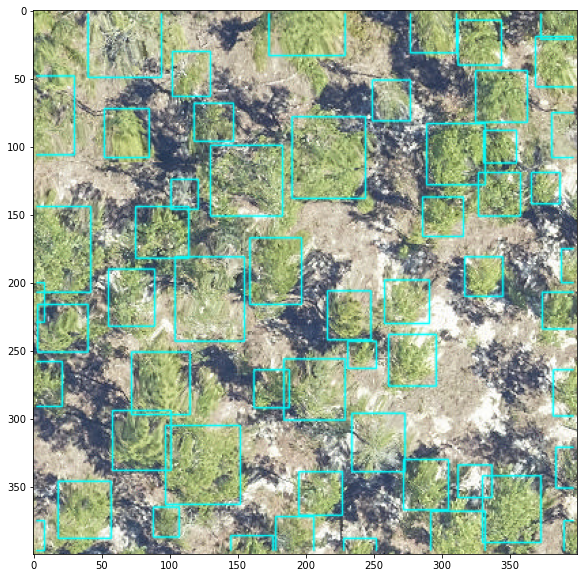

In [3]:
# Using a sample image from deep forest library
plt.rcParams['figure.figsize'] = [10, 10]
model = main.deepforest()
model.use_release()

sample_image = get_data("OSBS_029.png")
img = model.predict_image(path=sample_image, return_plot=True)

# img = model.predict_image(path="/Users/benweinstein/Documents/NeonTreeEvaluation/evaluation/RGB/TEAK_049_2019.tif",return_plot=True)

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order.
plt.imshow(img[:,:,::-1])

/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 9/9 [00:23<00:00,  2.64s/it]

270 predictions in overlapping windows, applying non-max supression
170 predictions kept after non-max suppression


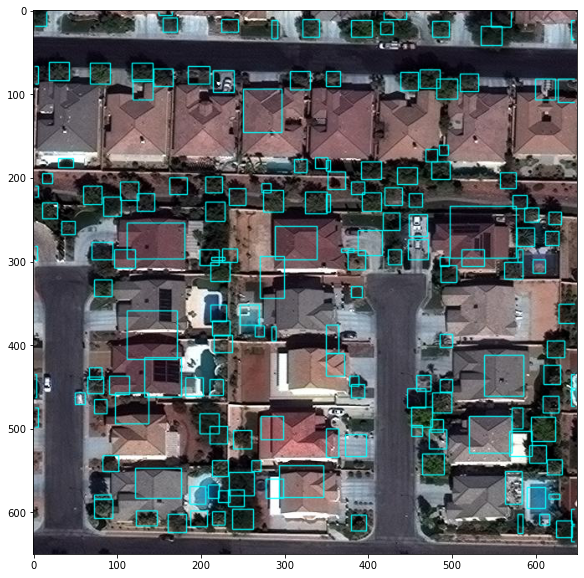

In [6]:
sample_image1 = './data/color_img.jpg'
predicted_raster = model.predict_tile(sample_image1, return_plot = True, patch_size=300,patch_overlap=0.05)
plt.imshow(predicted_raster[:,:,::-1])

In [8]:
# Training deepforest with new data
# Example run with short training
annotations_file = "./annotations_new_images.csv"
# annotations_file = get_data("example.csv")
model.config["train"]["epochs"] = 10
model.config["gpus"] = 0
model.config["workers"] = 10
# model.config["save-snapshot"] = False
model.config["train"]["csv_file"] = annotations_file
model.config["train"]["root_dir"] = os.path.dirname(annotations_file)
model.config["train"]["fast_dev_run"] = False
# model.config["validation"]["csv_file"] = annotations_file
# model.config["validation"]["root_dir"] = os.path.dirname(annotations_file)

model.create_trainer()
model.use_release()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [12]:
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training: {(time.time() - start_time):.2f} seconds ---")

/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.1 M
------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:378: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

--- Training: 165.24 seconds ---


/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

164 predictions in overlapping windows, applying non-max supression
119 predictions kept after non-max suppression


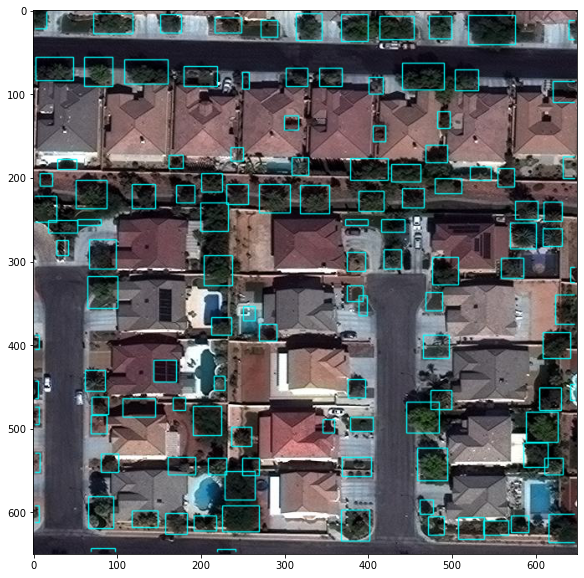

In [13]:
sample_image1 = './data/color_img.jpg'
predicted_raster = model.predict_tile(sample_image1, return_plot = True, patch_size=400,patch_overlap=0.05)
plt.imshow(predicted_raster[:,:,::-1])

In [ ]:
# These polygons were converted into masks (using some library) and used for semantic segmentation

In [3]:
data_dir = './data/trees/'
img_dir = os.path.join(data_dir, 'RGB+ELEV')
bldg_dir = os.path.join(data_dir, 'geojson_buildings')

# Prefix of all filename - naming convention
prefix = 'SN2_buildings_train_AOI_2_Vegas_'

2022-04-15 17:23:39.904710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-04-15 17:23:39.904756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


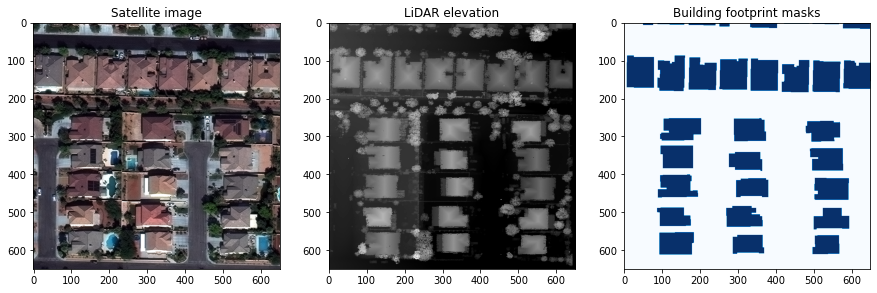

In [4]:
import libs.solaris as sol
import os, time, json, random
from pathlib import Path
from tqdm import tqdm
from p_tqdm import p_umap
import numpy as np
import pandas as pd
import skimage
# Show a data sample
sample = 'img1009' # chip ID, img? format

# Read in 4-channel image from GeoTIFF.
img_file = prefix + 'RGB+ELEV_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)
img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]

# Read in GeoJSON file and convert polygons to footprint mask.
bldg_file = prefix + 'geojson_buildings_' + sample + '.geojson'
bldg_path = os.path.join(bldg_dir, bldg_file)
mask = sol.vector.mask.footprint_mask(bldg_path, reference_im=img_path)

# Display satellite image and building footprint mask.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb)
ax[0].set_title('Satellite image')
ax[1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[1].set_title('LiDAR elevation')
ax[2].imshow(mask, cmap='Blues')
ax[2].set_title('Building footprint masks')
fig.show()

In [25]:
# Code to generate the rgb images from the RGB+LiDAR attribute image
rgb_dir = os.path.join(data_dir, 'rgb_buildings')

# This step is time-consuming, and only needs to be run once.
# After you have all the rgb images ready in folder `rgb_buildings/`,
# this operation will be skipped.
if not os.path.exists(rgb_dir):
    os.mkdir(rgb_dir)
    
    img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    for img_file in tqdm(img_file_list):
        # Get the `img[number]` chip ID from file name.
        chip_id = os.path.splitext(img_file)[0].split('_')[-1]
        img_path = os.path.join(img_dir, img_file)
        img = skimage.io.imread(img_path)
        rgb = img[..., :3]/255.0
        rgb_file = prefix + 'RGB_' + chip_id + '.png'
        rgb_path = os.path.join(rgb_dir, rgb_file)
        plt.imsave(rgb_path, rgb)


100%|██████████| 3084/3084 [14:53<00:00,  3.45it/s]


In [154]:
boxes = model.predict_tile(sample_image1, return_plot = False, patch_size=400,patch_overlap=0.05)
boxes

/home/ec2-user/anaconda3/envs/tutorial-env/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)

100%|██████████| 4/4 [00:00<00:00, 25.45it/s]

169 predictions in overlapping windows, applying non-max supression
124 predictions kept after non-max suppression


,xmin,ymin,xmax,ymax,label,score
0,62.0,57.0,94.0,91.0,Tree,0.799256
1,4.0,56.0,47.0,84.0,Tree,0.789720
2,368.0,5.0,400.0,37.0,Tree,0.772136
3,572.0,258.0,600.0,282.0,Tree,0.769616
4,617.0,604.0,648.0,637.0,Tree,0.753887
...,...,...,...,...,...,...
119,31.0,5.0,64.0,27.0,Tree,0.199174
120,108.0,464.0,145.0,485.0,Tree,0.192074
121,508.0,607.0,538.0,631.0,Tree,0.190870
122,605.0,451.0,631.0,477.0,Tree,0.179044


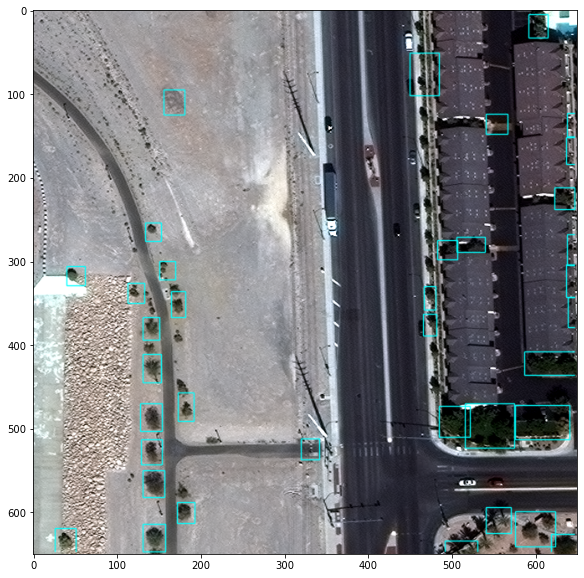

In [146]:
pred_image1= model.predict_image(path=annotation_path+'SN2_buildings_train_AOI_2_Vegas_RGB_img1003.png', return_plot=True)
plt.imshow(pred_image1[:,:,::-1])

In [123]:
#Find annotation path
annotation_path = "/home/ec2-user/SageMaker/deepforest_extras/"
#crop images will save in a newly created directory
#os.mkdir(os.getcwd(),'train_data_folder')
crop_dir = annotation_path+'train_data_folder'
train_annotations= preprocess.split_raster(path_to_raster=annotation_path+'SN2_buildings_train_AOI_2_Vegas_RGB_img1003.png',
                                 annotations_file=annotation_path+'annotations_new_images.csv',
                                 base_dir=crop_dir,
                                 patch_size=300,
                                 patch_overlap=0.05)

/home/ec2-user/anaconda3/envs/tutorial-env/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/ec2-user/anaconda3/envs/tutorial-env/lib/python3.8/site-packages/deepforest/preprocess.py:186: UserWarning: Input rasterio had non-3 band shape of (650, 650, 4), ignoring alpha channel
  warnings.warn("Input rasterio had non-3 band shape of {}, ignoring alpha channel".format(numpy_image.shape))
/home/ec2-user/anaconda3/envs/tutorial-env/lib/python3.8/site-packages/deepforest/preprocess.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_annotations.image_path = "{}_{}.

In [89]:
#Split image crops into training and test. Normally these would be different tiles! Just as an example.
image_paths = train_annotations.image_path.unique()
#split 25% validation annotation
valid_paths = np.random.choice(image_paths, int(len(image_paths)*0.25) )
valid_annotations = train_annotations.loc[train_annotations.image_path.isin(valid_paths)]
train_annotations = train_annotations.loc[~train_annotations.image_path.isin(valid_paths)]

In [90]:
#View output
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(valid_annotations.shape[0]))

#save to file and create the file dir
annotations_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(annotations_file,index=False)
valid_annotations.to_csv(validation_file,index=False)

There are 65 training crown annotations
There are 30 test crown annotations


In [133]:
#save the prediction result to a prediction folder
save_dir = os.path.join(os.getcwd(),'pred_result')
try:
  os.mkdir(save_dir)
except FileExistsError:
  pass
results = model.evaluate(annotations_file, os.path.dirname(annotations_file), iou_threshold = 0.4, savedir= save_dir)